In [1]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [2]:
print('Load 2019')
gedi_2019 = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_2019_may_28.csv")
print('Load 2020')
gedi_2020 = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_2020_may_28.csv")
print('Load 2021')
gedi_2021 = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_2021_may_28.csv")
print('Load 2022')
gedi_2022 = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_2022_may_28.csv")


Load 2019
Load 2020
Load 2021
Load 2022


In [3]:
gedi = pd.concat([gedi_2019, gedi_2020, gedi_2021, gedi_2022])
gedi

,Unnamed: 0,shot_number,longitude,latitude,...,SR_B4,SR_B5,SR_B6,SR_B7
0,166,55000500300288931,-117.996731,37.039413,...,12518.500,16430.000,17110.000,14962.250
1,170,55000500300288938,-117.993338,37.037050,...,12353.500,15856.750,17413.000,15194.500
2,171,55000500300288940,-117.992372,37.036376,...,11019.500,15106.250,15000.500,13174.250
3,173,55000500300288942,-117.991400,37.035700,...,11528.000,15291.250,16611.500,14396.500
4,175,55000500300288944,-117.990431,37.035025,...,11304.400,15523.800,15798.800,13847.000
...,...,...,...,...,...,...,...,...,...
2687894,27629254,214951100200080937,-119.274297,38.777115,...,13948.333,15819.417,17432.916,16291.000
2687895,27629255,214951100200080938,-119.273788,38.777441,...,13639.083,15451.250,17156.584,15985.167
2687896,27629256,214951100200080939,-119.273277,38.777767,...,13729.583,15459.000,17091.916,15957.583
2687897,27629257,214951100200080940,-119.272767,38.778093,...,13817.917,15544.667,17057.666,15883.250


In [4]:
unburned = gedi[(gedi.burn_severity_std==0) & (gedi.burn_counts_std==0) & (gedi.burn_counts_mean == 0) & (gedi.burn_severity_mean==0)]

In [5]:
unburned.columns

Index(['Unnamed: 0', 'shot_number', 'longitude', 'latitude', 'agbd',
       'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se', 'beam_type', 'sensitivity',
       'pft_class', 'gedi_year', 'gedi_month', 'absolute_time',
       'burn_severity_2x2', 'burn_severity_mean', 'burn_severity_std',
       'burn_severity_median', 'burn_year_2x2', 'burn_year_mean',
       'burn_year_std', 'burn_year_median', 'burn_counts_2x2',
       'burn_counts_mean', 'burn_counts_std', 'burn_counts_median',
       'elevation', 'slope', 'aspect', 'soil', 'land_cover', 'nbr', 'ndvi',
       'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],
      dtype='object')

In [7]:
unburned =  unburned[unburned.land_cover == 1]

In [6]:
columns_to_use = ['agbd', 'pft_class', 'elevation', 'slope', 'aspect', 'soil', 'nbr', 'ndvi',
'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

In [8]:
df = unburned[columns_to_use]

In [85]:
df.dtypes

agbd         float64
pft_class      int64
elevation      int64
slope          int64
aspect         int64
soil           int64
nbr          float64
ndvi         float64
SR_B1        float64
SR_B2        float64
SR_B3        float64
SR_B4        float64
SR_B5        float64
SR_B6        float64
SR_B7        float64
dtype: object

In [9]:
procs = [Categorify, FillMissing, Normalize]

In [10]:
dep_var = 'agbd'

In [11]:
df = df[df.agbd != 0]

In [12]:
df[dep_var] = np.log(df[dep_var])

In [13]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)


In [14]:
splits = RandomSplitter()(range_of(df))

In [15]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [16]:
len(to.train),len(to.valid)


(2771741, 692935)

In [17]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

### Decision Tree Regressor

In [20]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [96]:
m = DecisionTreeRegressor(max_leaf_nodes=10)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=10)

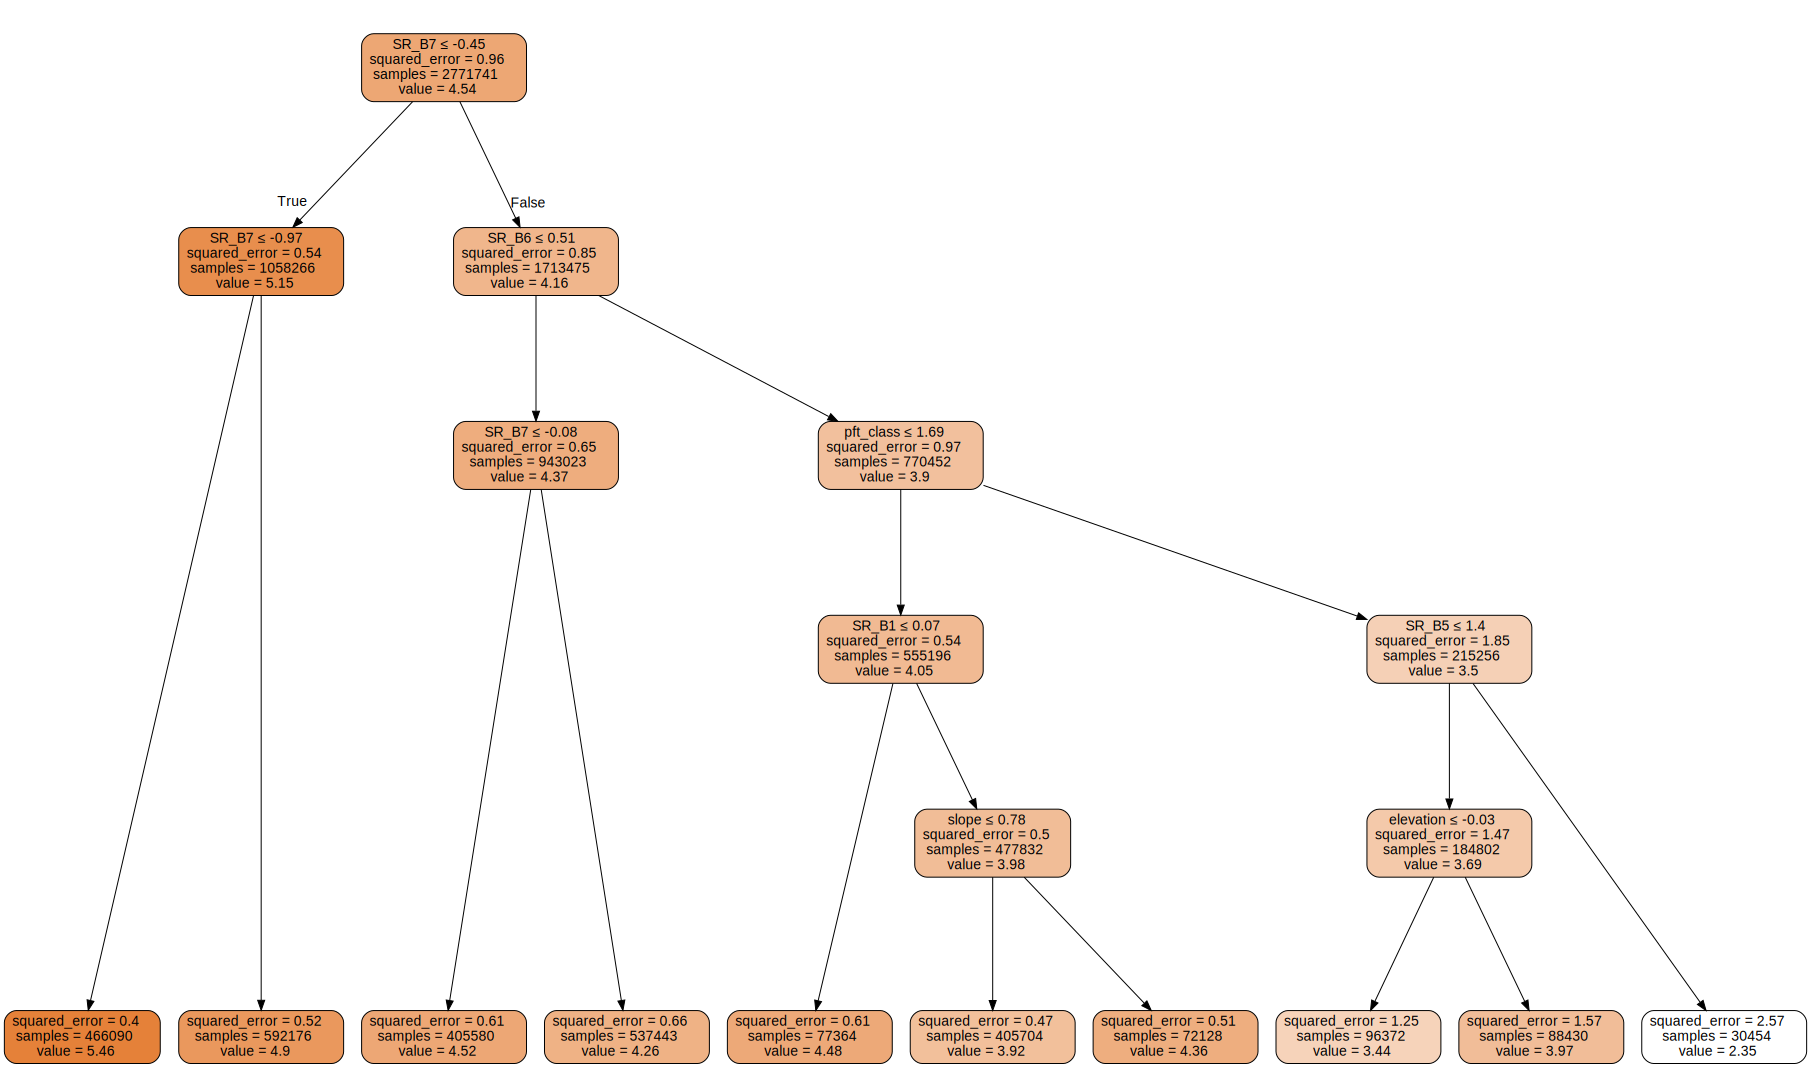

In [97]:
draw_tree(m, xs, size=100, leaves_parallel=True, precision=2)

In [98]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.782712, 0.784991)

### Random Forest

In [18]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [21]:
m = rf(xs, y)

In [101]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.658271, 0.685687)

In [22]:
np.exp(np.log(100) + 0.65)

191.55408290138976

In [23]:
np.exp(m.predict(xs)), np.exp(y)

(array([ 78.9382734 ,  62.60105487,   4.31804626, ..., 104.7317702 , 210.77194359,  46.40647539]),
 1338775     54.148731
 25419      170.484879
 1315351     13.754204
 326268      60.844574
 1478632     49.094597
               ...    
 1295352     17.643862
 150576      58.483219
 363359     126.119553
 1601329    172.835785
 1340740     54.758991
 Name: agbd, Length: 2771741, dtype: float32)

In [24]:
from src.processing.control import placebo
placebo.calculate_rmse(np.exp(m.predict(xs)), np.exp(y))

2.056388

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

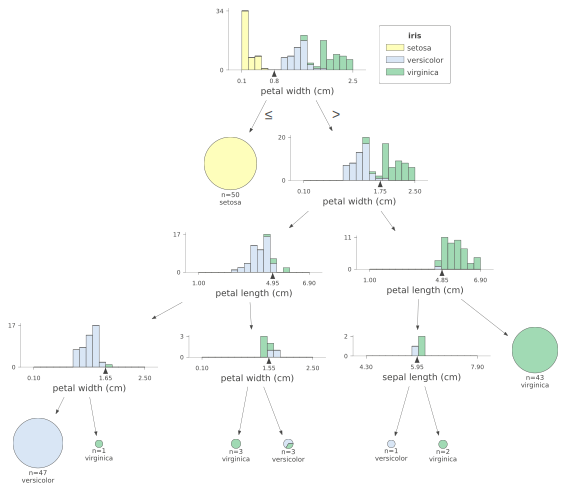

In [26]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

import dtreeviz

iris = load_iris()
X = iris.data
y = iris.target

clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X, y)

viz_model = dtreeviz.model(clf,
                           X_train=X, y_train=y,
                           feature_names=iris.feature_names,
                           target_name='iris',
                           class_names=iris.target_names)

viz_model.view()     # render as SVG into internal object 